In [1]:
import os
import cv2
import lmdb
from random import Random
from matplotlib import pyplot as plt
from psutil import virtual_memory
import click
import time
from glob import glob
import numpy as np
import math
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from PIL import Image
from Model import Model
from writeFileList import writeFileList
from TrainingSet import TrainingSet
from test import plot

# Model and Train

### Run the following cell for the first time you load your data & save the paths in a numpy array

In [ ]:
#dirName = 'D:\\workspace\\proj7643\\CampusLoopDataset\\live'
dirName = 'D:\\workspace\\data\\train_256_places365challenge'
t0 = time.time()
files_list,total_number = writeFileList(dirName)
t1 = time.time()
print ('\n\nLoading Paths: ', (t1-t0) , ' seconds')

array_list=np.array(files_list)
np.save('files_list.npy',array_list)
array_total_number=np.array(total_number)
np.save('total_number.npy',array_total_number)

### Run the following cell to load the paths you've saved

In [5]:
array_list=np.load('files_list.npy')
files_list=array_list.tolist()
array_total_number=np.load('total_number.npy')
total_number=array_total_number.tolist()



Loading Paths:  1826.6531043052673  seconds


### Initializing the Model

In [6]:
device  = torch.device("cuda:0")

model = Model().to(device)
#PATH = 'model\\model.pth'
#model.load_state_dict(torch.load(PATH))
#criterion = nn.MSELoss(reduction = 'sum')

### Setting up optimizer and loss function

In [7]:
criterion = nn.MSELoss()
#criterion = nn.L1Loss(reduction = 'sum')
optimizer = optim.Adam(model.parameters(), lr=1e-5,weight_decay=0.995)

### Train

In [ ]:
batch_size = 512
PATH = 'model\\model.pth'
trainingset = TrainingSet(files_list,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
max_epochs = 100
iters = math.ceil(total_number/batch_size)
for epoch in range(max_epochs):
    avgloss = 0.0 # This loss is the average loss of an epoch
    t0 = time.time()
    for i,data in enumerate(trainloader):
        imgs,desps = data
        #print(imgs.shape)
        #print(desps.shape)
        #temp = imgs[0,:,:,:].reshape(120,160,1)
        #print(temp)
        #img = cv2.cvtColor(np.uint8(temp),cv2.IMREAD_GRAYSCALE)
        #plt.imshow(img)
        #plt.axis('off')
        #plt.show()
        #imgs,desps = data
        #print(imgs.dtype)
        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        #cv2.imshow(imgs)
        #print(torch.mean(desps))
        optimizer.zero_grad()
        outputs = model(imgs)
        #print(outputs[22,:])
        #print(desps[0,:])
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        #print('loss:%.3f'%loss.item())
        avgloss += loss.item()
        print('[Epoch %d,iteration %d] loss: %5f'%(epoch + 1,i+1,loss.item()))
        if i%iters==iters-1:#According to the size of the dataset and batchsize
            print('[Epoch %d] loss: %.3f time used: %.3f' %
                      (epoch + 1, avgloss / iters,time.time()-t0))
            avgloss = 0.0
    if epoch%100 == 99:
        CP_PATH = 'model\\model_'+str(epoch)+'.pth'
        torch.save(model.state_dict(),CP_PATH)
    elif epoch%20 == 19:
        torch.save(model.state_dict(), PATH)
        print('small step checkpoint saved')
        

### AlexNet implementation

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
device  = torch.device("cuda:0")
alexnet = models.alexnet(pretrained=True,progress=True).to(device)
#print(alexnet)
#print(alexnet.features[0].parameters())

### Modify the input and output layers

In [ ]:
#print(alexnet)
#alexnet = alexnet.to(device)
alexnet.features[0] = nn.Conv2d(in_channels=1,out_channels=64,kernel_size=11,stride=4,padding=2)
alexnet.classifier[6] = nn.Linear(4096,3648)
lr = 1e-5
optimizer = optim.Adam(alexnet.parameters(), lr=lr,weight_decay=0.995)

#in_layer_params = list(alexnet.features[0].parameters())
#out_layer1_params = list(alexnet.classifier[6].parameters())
#out_layer2_params = list(alexnet.classifier[4].parameters())
#out_layer3_params = list(alexnet.classifier[1].parameters())
#print(alexnet.features[0])
#base_params = filter(lambda p: id(p) not in in_layer_params+out_layer1_params+out_layer2_params+out_layer3_params,alexnet.parameters())
#base_params2 = list(map(id, alexnet.avgpool[0].parameters()))
#base_params3 = filter(lambda p: id(p) not in out_layer1_params+out_layer2_params+out_layer3_params,alexnet.classifier.parameters())

#for i in optimizer.param_groups:
#    print(i)
#    for k,v in i.items():
#        print(k)
#print(in_layer_params,out_layer1_params,out_layer2_params,out_layer3_params)
#print(base_params2)
#optimizer = optim.Adam([{'params': alexnet.features[0].parameters()},
#                        {'params': alexnet.classifier[6].parameters(),'lr': lr*1e5},
#                        {'params': alexnet.classifier[4].parameters(),'lr': lr*1e5},
#                        {'params': alexnet.classifier[1].parameters(),'lr': lr*1e5}],
#                       lr=lr,weight_decay=0.995)
alexnet.cuda()

### train

In [33]:
PATH = 'model\\alexnet.pth'
#model.load_state_dict(torch.load(PATH))
criterion = nn.MSELoss(reduction = 'sum')
#criterion = nn.L1Loss(reduction = 'sum')

batch_size = 512
trainingset = TrainingSet(files_list,total_number)
trainloader = DataLoader(trainingset,batch_size,shuffle=True)
max_epochs = 100
iters = math.ceil(total_number/batch_size)
for epoch in range(max_epochs):
    avgloss = 0.0 # This loss is the average loss of an epoch
    t0 = time.time()
    for i,data in enumerate(trainloader):
        imgs,desps = data
        #print(imgs.shape)
        #print(desps.shape)
        temp = imgs[0,:,:,:].reshape(120,160,1)
        #print(temp)
        img = cv2.cvtColor(np.uint8(temp),cv2.IMREAD_GRAYSCALE)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        for ii in range(3648):
            print(desps[0][ii],desps[1][ii],desps[2][ii],desps[3][ii],desps[4][ii],desps[5][ii])
        #imgs,desps = data
        #print(imgs.dtype)
        imgs,desps = imgs.to(device=device,dtype=torch.float), desps.to(device=device,dtype=torch.float)
        #cv2.imshow(imgs)
        #print(torch.mean(desps))
        optimizer.zero_grad()
        outputs = alexnet(imgs)
        #print(outputs[22,:])
        #print(desps[0,:])
        loss = criterion(outputs,desps)
        loss.backward()
        optimizer.step()
        #print('loss:%.3f'%loss.item())
        avgloss += loss.item()
        print('[Epoch %d,iteration %d] loss: %5f'%(epoch + 1,i+1,loss.item()))
        if i%iters==iters-1:#According to the size of the dataset and batchsize
            print('[Epoch %d] loss: %.3f time used: %.3f' %
                      (epoch + 1, avgloss / iters,time.time()-t0))
            avgloss = 0.0
    if epoch%100 == 99:
        CP_PATH = 'model\\model_'+str(epoch)+'.pth'
        torch.save(model.state_dict(),CP_PATH)
    #elif epoch%20 == 19:
    torch.save(model.state_dict(), PATH)
    print('small step checkpoint saved')
        

ValueError: cannot reshape array of size 14592 into shape (3648,)

# Test and evaluation

memory path:  D:\workspace\proj7643\CampusLoopDataset\memory
live path:  D:\workspace\proj7643\CampusLoopDataset\live
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image001.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image002.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image003.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image004.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image005.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image006.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image007.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image008.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image009.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image010.jpg  to database
lo

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
0.04188823699951172
Proposed match calc: 001 ,  013 , score =  [[1.0000001]] , Correct = [0]
Proposed match 

[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
0.04288506507873535
Proposed match c

[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999998]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
0.042885541915893555
Proposed match calc: 017 ,  001 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 017 ,  061 , score =  0.99800014 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]


[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
0.042884111404418945
Proposed match calc: 025 ,  007 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 025 ,  061 , score =  0.9922111 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]

[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.0000002]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
0.04188728332519531
Proposed match calc: 034 ,  041 , score =  [[1.0000002]] , Correct = [0]
Proposed match HOG: 034 ,  061 , 

[[0.99999994]]
0.04188704490661621
Proposed match calc: 041 ,  007 , score =  [[1.0000001]] , Correct = [0]
Proposed match HOG: 041 ,  061 , score =  0.9991187 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994

[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.9999998]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
0.04088926315307617
Proposed match calc: 050 ,  004 , score =  [[1.0000001]] , Correct = [0

[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
0.042886257171

[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.0000001]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[1.]

[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
0.040891408920288086
Proposed match calc: 074 ,  007 , score =  [[1.0000002]] , Correct = [0]
Proposed match HOG: 074 ,  061 , score =  0.99934834 , Correct = 0


[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.0000001]]
[[1.0000002]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.0000002]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.

[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1

[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.0000001]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[1.0000001]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.0000001]]
[[1.]]
0.04288530349731445
Proposed match calc: 0

[[0.9999999]]
[[1.]]
[[0.99999994]]
[[1.]]
[[1.]]
[[1.]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.99999994]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999998]]
[[1.]]
[[1.]]
[[1.]]
[[1.]]
[[0.9999999]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[1.]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[0.99999994]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[0.9999999]]
[[0.9999999]]
[[1.]]
[[0.99999994]]
0.04188847541809082
Proposed match calc: 099 ,  007 , score =  [[1.]] , Correct = [0]
Proposed match HOG: 099 ,  061 , score =  0.9704818 , Correct = 0


[[1.0000001]]
[[1.]]
[[1.]]
[[0.99999994]]
[[0.9999999]]
[[1.]]
[[1.0000001]]
[[1.]]
[[

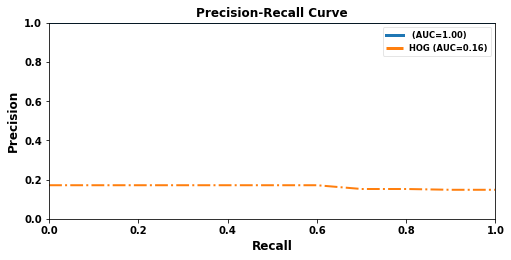

In [40]:
modelpath = PATH
#datapath = 'D:\\workspace\\data\\dataset\\06\\test'
#datapath = 'D:\\workspace\\data\\spring_summer'
datapath = 'D:\\workspace\\proj7643\\CampusLoopDataset'
plot(model,datapath)

memory path:  D:\workspace\proj7643\CampusLoopDataset\memory
live path:  D:\workspace\proj7643\CampusLoopDataset\live
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image001.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image002.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image003.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image004.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image005.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image006.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image007.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image008.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image009.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image010.jpg  to database
lo

loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image098.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image099.jpg  to database
loading image  D:\workspace\proj7643\CampusLoopDataset\memory\Image100.jpg  to database
[[0.9950303]]
[[0.9944846]]
[[0.99548614]]
[[0.99308634]]
[[0.9936621]]
[[0.99545383]]
[[0.9953032]]
[[0.99510586]]
[[0.9964047]]
[[0.994125]]
[[0.996364]]
[[0.9941172]]
[[0.99444324]]
[[0.9957541]]
[[0.98735595]]
[[0.99597764]]
[[0.99381757]]
[[0.995323]]
[[0.9968758]]
[[0.9962291]]
[[0.9960645]]
[[0.99398434]]
[[0.9960171]]
[[0.99476635]]
[[0.9949911]]
[[0.9941807]]
[[0.99774826]]
[[0.9942572]]
[[0.99785775]]
[[0.99292815]]
[[0.9958748]]
[[0.9934138]]
[[0.99291706]]
[[0.9965291]]
[[0.9961316]]
[[0.99503803]]
[[0.99645674]]
[[0.99141717]]
[[0.9938197]]
[[0.99694496]]
[[0.99399483]]
[[0.9945822]]
[[0.99532956]]
[[0.9929103]]
[[0.9955636]]
[[0.99541426]]
[[0.9947914]]
[[0.9952867]]
[[0.992594]]
[[0.99247444]]
[[0.9960326]]
[[0.

[[0.99298835]]
[[0.99169016]]
[[0.99325025]]
[[0.9949101]]
[[0.9910834]]
[[0.9913275]]
[[0.993523]]
[[0.9938675]]
[[0.99364924]]
[[0.9914212]]
[[0.9945738]]
[[0.9927003]]
[[0.9927096]]
[[0.98756456]]
[[0.99353963]]
[[0.99299777]]
[[0.99132895]]
[[0.99433935]]
[[0.99416566]]
[[0.9947155]]
[[0.9902185]]
[[0.9940754]]
[[0.9915565]]
[[0.9916107]]
[[0.9940891]]
[[0.99539447]]
[[0.9910959]]
[[0.9934742]]
[[0.9933158]]
[[0.9925849]]
[[0.98966146]]
[[0.9924728]]
[[0.9913775]]
[[0.9910655]]
[[0.9925122]]
[[0.99536407]]
[[0.99083585]]
[[0.9869541]]
[[0.99432695]]
[[0.99073696]]
[[0.9944805]]
[[0.9938841]]
[[0.992831]]
[[0.9961381]]
[[0.99450856]]
[[0.99236584]]
[[0.9912312]]
[[0.98894966]]
[[0.99246836]]
[[0.99425143]]
[[0.9945206]]
[[0.9936522]]
[[0.989831]]
[[0.9949254]]
[[0.99388766]]
[[0.9889538]]
[[0.9940924]]
[[0.99379134]]
[[0.9927958]]
[[0.99238396]]
[[0.994785]]
[[0.99186325]]
[[0.9908177]]
[[0.9949726]]
[[0.9956664]]
[[0.99230105]]
[[0.99156976]]
[[0.98949003]]
[[0.9949219]]
[[0.992161

[[0.99388593]]
[[0.9923049]]
[[0.99478555]]
[[0.9918038]]
[[0.9931667]]
[[0.99347484]]
[[0.99555993]]
[[0.99527824]]
[[0.9948375]]
[[0.9944542]]
[[0.99432576]]
[[0.99371755]]
[[0.99485195]]
[[0.9955034]]
[[0.988691]]
[[0.99335265]]
[[0.99437416]]
[[0.99529904]]
[[0.99629086]]
[[0.99447286]]
[[0.99686897]]
[[0.99517226]]
[[0.99647146]]
[[0.9931114]]
[[0.9951812]]
[[0.9936067]]
[[0.99561876]]
[[0.99566954]]
[[0.99634194]]
[[0.9942314]]
[[0.9953976]]
[[0.99361706]]
[[0.99162996]]
[[0.9937835]]
[[0.99395466]]
[[0.99547493]]
[[0.99414086]]
[[0.99364954]]
[[0.9936166]]
[[0.99570256]]
[[0.99072814]]
[[0.994279]]
[[0.9944527]]
[[0.994197]]
[[0.9953059]]
[[0.9951879]]
[[0.9944653]]
[[0.9943787]]
[[0.9924155]]
[[0.9940509]]
[[0.9960162]]
[[0.9939749]]
[[0.992942]]
[[0.9927084]]
[[0.9947969]]
[[0.9949757]]
[[0.9946238]]
[[0.9961287]]
[[0.9943168]]
[[0.99406683]]
[[0.9931228]]
[[0.99347305]]
[[0.99583364]]
[[0.99103856]]
[[0.995005]]
[[0.9961029]]
[[0.99489343]]
[[0.9927136]]
[[0.991138]]
[[0.9951

[[0.99328935]]
[[0.9936512]]
[[0.9920601]]
[[0.99492675]]
[[0.99221206]]
[[0.99246347]]
[[0.99393976]]
[[0.99417686]]
[[0.9946972]]
[[0.9941839]]
[[0.995139]]
[[0.9935169]]
[[0.9937054]]
[[0.98956245]]
[[0.9928254]]
[[0.9934763]]
[[0.99327385]]
[[0.9953339]]
[[0.9944047]]
[[0.9946128]]
[[0.9935757]]
[[0.99434143]]
[[0.9923372]]
[[0.9944244]]
[[0.9940023]]
[[0.99539477]]
[[0.9927707]]
[[0.99489725]]
[[0.9917634]]
[[0.99493015]]
[[0.99355954]]
[[0.9913528]]
[[0.9933528]]
[[0.991731]]
[[0.99396]]
[[0.9958003]]
[[0.99069864]]
[[0.99214846]]
[[0.99436176]]
[[0.9923134]]
[[0.99409235]]
[[0.9934635]]
[[0.9942341]]
[[0.995218]]
[[0.9947667]]
[[0.9934294]]
[[0.99403626]]
[[0.990493]]
[[0.9913974]]
[[0.99579674]]
[[0.99481523]]
[[0.9940274]]
[[0.99142134]]
[[0.99359775]]
[[0.99556744]]
[[0.99280995]]
[[0.9950367]]
[[0.9945905]]
[[0.9931536]]
[[0.993216]]
[[0.99398077]]
[[0.9941722]]
[[0.9917268]]
[[0.9953587]]
[[0.9960791]]
[[0.9929469]]
[[0.99337864]]
[[0.9903399]]
[[0.995761]]
[[0.9932476]]
[[

[[0.9934105]]
[[0.9917354]]
[[0.99255097]]
[[0.9924372]]
[[0.99078643]]
[[0.9901234]]
[[0.99265647]]
[[0.993232]]
[[0.9935953]]
[[0.99211425]]
[[0.9922135]]
[[0.99420625]]
[[0.99255157]]
[[0.99060374]]
[[0.99387556]]
[[0.99274987]]
[[0.99350226]]
[[0.99484557]]
[[0.99412024]]
[[0.99517655]]
[[0.99265635]]
[[0.993328]]
[[0.9898356]]
[[0.9922541]]
[[0.99346495]]
[[0.9947274]]
[[0.9917619]]
[[0.99417853]]
[[0.992242]]
[[0.9920739]]
[[0.994227]]
[[0.9898429]]
[[0.99171203]]
[[0.9932543]]
[[0.9934572]]
[[0.99299514]]
[[0.9906284]]
[[0.9917264]]
[[0.9941373]]
[[0.99205005]]
[[0.9943317]]
[[0.9920672]]
[[0.99325496]]
[[0.9939736]]
[[0.9933914]]
[[0.9928343]]
[[0.99143]]
[[0.98952067]]
[[0.9905275]]
[[0.99367476]]
[[0.99494654]]
[[0.99228925]]
[[0.99196047]]
[[0.99375486]]
[[0.994244]]
[[0.9923359]]
[[0.99545866]]
[[0.9906278]]
[[0.9910215]]
[[0.99374497]]
[[0.99240875]]
[[0.99161434]]
[[0.9882832]]
[[0.99335015]]
[[0.9951081]]
[[0.9945912]]
[[0.9916612]]
[[0.99112284]]
[[0.99460334]]
[[0.9944

[[0.99327743]]
[[0.99533397]]
[[0.993892]]
[[0.99497056]]
[[0.9946375]]
[[0.9953638]]
[[0.9956734]]
[[0.9943855]]
[[0.9939325]]
[[0.9952887]]
[[0.9953277]]
[[0.9941038]]
[[0.9957106]]
[[0.9907075]]
[[0.9940197]]
[[0.9940795]]
[[0.99649835]]
[[0.9965892]]
[[0.996158]]
[[0.99592596]]
[[0.9950278]]
[[0.9968133]]
[[0.9948396]]
[[0.9945565]]
[[0.996245]]
[[0.99642646]]
[[0.9937413]]
[[0.996323]]
[[0.9940471]]
[[0.9948699]]
[[0.99178755]]
[[0.994802]]
[[0.99407953]]
[[0.994362]]
[[0.9963297]]
[[0.99579173]]
[[0.99163264]]
[[0.9923606]]
[[0.9961441]]
[[0.9947549]]
[[0.99633944]]
[[0.9954809]]
[[0.99517655]]
[[0.994577]]
[[0.99560547]]
[[0.9963762]]
[[0.994617]]
[[0.9942139]]
[[0.9921775]]
[[0.9960851]]
[[0.9941298]]
[[0.9946786]]
[[0.9943701]]
[[0.9968617]]
[[0.99599195]]
[[0.9927831]]
[[0.9947462]]
[[0.99626476]]
[[0.9932033]]
[[0.9940148]]
[[0.99498856]]
[[0.99393284]]
[[0.9928524]]
[[0.9951593]]
[[0.99677765]]
[[0.9935664]]
[[0.9959507]]
[[0.9902054]]
[[0.99629974]]
[[0.99400806]]
[[0.9943

[[0.99489415]]
[[0.99424404]]
[[0.99202186]]
[[0.9928347]]
[[0.9950098]]
[[0.9928733]]
[[0.99530834]]
[[0.9942367]]
[[0.9935963]]
[[0.9946543]]
[[0.99490464]]
[[0.99555296]]
[[0.99552643]]
[[0.9937139]]
[[0.99378717]]
[[0.9959641]]
[[0.9943101]]
[[0.9930743]]
[[0.9943893]]
[[0.99479556]]
[[0.99609804]]
[[0.9940691]]
[[0.99512583]]
[[0.9962325]]
[[0.99349535]]
[[0.9941943]]
[[0.99447614]]
[[0.99576426]]
[[0.9919325]]
[[0.9945859]]
[[0.99625105]]
[[0.993981]]
[[0.9936818]]
[[0.9924892]]
[[0.9961042]]
[[0.99281424]]
[[0.9938663]]
[[0.99348414]]
[[0.9937767]]
[[0.99443233]]
[[0.9937784]]
[[0.9949354]]
[[0.99217314]]
[[0.99274534]]
[[0.99261534]]
[[0.99501574]]
[[0.99462485]]
[[0.9934161]]
[[0.99515975]]
[[0.9959496]]
[[0.9939982]]
[[0.99033105]]
[[0.9930519]]
[[0.9952737]]
[[0.9940098]]
[[0.99518657]]
[[0.9921924]]
[[0.99215424]]
[[0.9953053]]
[[0.9947405]]
[[0.9956783]]
[[0.9951418]]
[[0.9937101]]
[[0.9938847]]
[[0.99447846]]
0.042859792709350586
Proposed match calc: 036 ,  023 , score = 

[[0.99044853]]
[[0.99135476]]
[[0.9895235]]
[[0.991238]]
[[0.9880502]]
[[0.9923679]]
[[0.9950706]]
[[0.991261]]
[[0.99134207]]
[[0.98505396]]
[[0.9911852]]
[[0.98862046]]
[[0.9916393]]
[[0.9909754]]
[[0.9876268]]
[[0.9922924]]
[[0.9934195]]
[[0.9901444]]
[[0.9895015]]
[[0.9915879]]
[[0.9928928]]
[[0.98989356]]
[[0.9908327]]
[[0.9934722]]
[[0.9915341]]
[[0.9927101]]
[[0.98828226]]
[[0.983835]]
[[0.99425524]]
[[0.9921641]]
[[0.9923601]]
[[0.9921339]]
[[0.99206007]]
[[0.9923234]]
[[0.9919306]]
[[0.9894451]]
[[0.98984504]]
[[0.9932143]]
[[0.98910415]]
[[0.9921312]]
[[0.9929056]]
0.043883562088012695
Proposed match calc: 041 ,  021 , score =  [[0.9952511]] , Correct = [0]
Proposed match HOG: 041 ,  061 , score =  0.9991187 , Correct = 0


[[0.9916707]]
[[0.99345136]]
[[0.9944832]]
[[0.99074185]]
[[0.99082667]]
[[0.99247533]]
[[0.9925406]]
[[0.9911282]]
[[0.99364454]]
[[0.98979366]]
[[0.9942068]]
[[0.9926445]]
[[0.99231845]]
[[0.9944638]]
[[0.98150796]]
[[0.9931393]]
[[0.9911981]]
[[0.993350

[[0.9890326]]
[[0.98628604]]
[[0.99036163]]
[[0.9912052]]
[[0.9887258]]
[[0.9916388]]
[[0.9834805]]
[[0.9879892]]
[[0.9926603]]
[[0.98811364]]
[[0.98977137]]
[[0.9912547]]
[[0.98900867]]
[[0.9914397]]
[[0.9921626]]
[[0.9888754]]
[[0.98758155]]
[[0.9861861]]
[[0.990526]]
[[0.99165726]]
[[0.9897065]]
[[0.9881113]]
[[0.9871688]]
[[0.9906837]]
[[0.99158233]]
[[0.9897548]]
[[0.99033576]]
[[0.9910366]]
[[0.99019814]]
[[0.98932433]]
[[0.9887169]]
[[0.99092937]]
[[0.98669446]]
[[0.9883676]]
[[0.9936306]]
[[0.9904383]]
[[0.9884547]]
[[0.9875297]]
[[0.9899484]]
[[0.9875584]]
[[0.98971474]]
[[0.98740757]]
[[0.9890014]]
[[0.99219215]]
[[0.9879885]]
[[0.99052453]]
[[0.9879501]]
[[0.991455]]
[[0.99155116]]
[[0.98819053]]
[[0.98944724]]
[[0.99065036]]
[[0.98822093]]
[[0.99264586]]
[[0.9902018]]
[[0.98203987]]
[[0.99267095]]
[[0.99211025]]
[[0.9887422]]
[[0.99318963]]
[[0.9887521]]
[[0.9906714]]
[[0.99291164]]
[[0.9879897]]
[[0.99028116]]
[[0.99095935]]
[[0.9894405]]
[[0.99008733]]
[[0.9906163]]
0.040

[[0.99416995]]
[[0.9943126]]
[[0.99474126]]
[[0.9913899]]
[[0.9952149]]
[[0.99159855]]
[[0.9910716]]
[[0.9926503]]
[[0.9946515]]
[[0.9940016]]
[[0.9943311]]
[[0.99516463]]
[[0.993328]]
[[0.99555045]]
[[0.9899894]]
[[0.99179363]]
[[0.9925481]]
[[0.99451655]]
[[0.99626446]]
[[0.9951807]]
[[0.9958397]]
[[0.9944617]]
[[0.995087]]
[[0.99254626]]
[[0.9941256]]
[[0.99497116]]
[[0.99553037]]
[[0.9916595]]
[[0.99567944]]
[[0.9945508]]
[[0.9960959]]
[[0.9944558]]
[[0.9916817]]
[[0.9908806]]
[[0.9929061]]
[[0.99416095]]
[[0.996213]]
[[0.99002695]]
[[0.9898642]]
[[0.99446636]]
[[0.9936873]]
[[0.99519145]]
[[0.9950944]]
[[0.99560297]]
[[0.9953057]]
[[0.99529034]]
[[0.99291295]]
[[0.99403]]
[[0.9917099]]
[[0.9940665]]
[[0.9960917]]
[[0.9958938]]
[[0.9958604]]
[[0.99219066]]
[[0.99443877]]
[[0.99687344]]
[[0.9930703]]
[[0.99361753]]
[[0.99447703]]
[[0.9921441]]
[[0.9950266]]
[[0.99405444]]
[[0.99268436]]
[[0.99034584]]
[[0.9966438]]
[[0.9969974]]
[[0.99253607]]
[[0.99283797]]
[[0.9879941]]
[[0.995123

[[0.994895]]
[[0.9957542]]
[[0.99332803]]
[[0.9951906]]
[[0.9933047]]
[[0.9949007]]
[[0.9952285]]
[[0.99217546]]
[[0.9944674]]
[[0.9956745]]
[[0.9940216]]
[[0.9942662]]
[[0.9894602]]
[[0.99386215]]
[[0.9955218]]
[[0.9936515]]
[[0.9948641]]
[[0.99453545]]
[[0.99341404]]
[[0.99385285]]
[[0.99468696]]
[[0.9963345]]
[[0.9932797]]
[[0.9926201]]
[[0.99191296]]
[[0.9960083]]
[[0.9941399]]
[[0.99440813]]
[[0.99248147]]
[[0.9946711]]
[[0.9956953]]
[[0.99289566]]
[[0.9946749]]
[[0.99558496]]
[[0.9930948]]
[[0.9952687]]
[[0.99387693]]
[[0.9938033]]
[[0.99179435]]
[[0.99344075]]
[[0.99637735]]
[[0.99498796]]
[[0.99293995]]
[[0.9924606]]
[[0.9961077]]
[[0.99209034]]
[[0.99561286]]
[[0.99325144]]
[[0.9945216]]
[[0.99583554]]
[[0.99441016]]
[[0.9936553]]
[[0.9921274]]
[[0.99151635]]
[[0.9923497]]
[[0.9947727]]
[[0.99585557]]
[[0.99408126]]
[[0.9961828]]
[[0.99501926]]
[[0.99490726]]
[[0.9877914]]
[[0.993642]]
[[0.9938005]]
[[0.99436116]]
[[0.99543583]]
[[0.9933294]]
[[0.9933899]]
[[0.9955709]]
[[0.99

[[0.9931099]]
[[0.99262136]]
[[0.99315614]]
[[0.9932771]]
[[0.99527776]]
[[0.99414825]]
[[0.99301803]]
[[0.99432]]
[[0.9958076]]
[[0.99566245]]
[[0.9917707]]
[[0.9931882]]
[[0.99329525]]
[[0.995215]]
[[0.98866105]]
[[0.9933085]]
[[0.9914471]]
[[0.99316853]]
[[0.99651587]]
[[0.99566483]]
[[0.99743855]]
[[0.99309886]]
[[0.9959893]]
[[0.99126756]]
[[0.9934564]]
[[0.99535173]]
[[0.995096]]
[[0.9946186]]
[[0.9963732]]
[[0.9930298]]
[[0.9948842]]
[[0.9914224]]
[[0.99308115]]
[[0.9921446]]
[[0.99321026]]
[[0.9928503]]
[[0.99356216]]
[[0.99322397]]
[[0.99003756]]
[[0.9954856]]
[[0.99182594]]
[[0.9961492]]
[[0.99463534]]
[[0.9937916]]
[[0.99459517]]
[[0.99418277]]
[[0.9929348]]
[[0.99524176]]
[[0.9892118]]
[[0.9944552]]
[[0.99428046]]
[[0.9933963]]
[[0.99191225]]
[[0.9932823]]
[[0.9945898]]
[[0.9957288]]
[[0.99248165]]
[[0.99595857]]
[[0.99384296]]
[[0.994124]]
[[0.9935062]]
[[0.99358153]]
[[0.9958259]]
[[0.9896823]]
[[0.9953269]]
[[0.99516666]]
[[0.99533975]]
[[0.9914925]]
[[0.9935113]]
[[0.99

[[0.99511266]]
[[0.9919761]]
[[0.9930052]]
[[0.99383956]]
[[0.9908016]]
[[0.99200946]]
[[0.9928547]]
[[0.9944376]]
[[0.99035627]]
[[0.9920583]]
[[0.99292064]]
[[0.9942343]]
[[0.99271625]]
[[0.985736]]
[[0.9934383]]
[[0.9906396]]
[[0.9919371]]
[[0.99253744]]
[[0.9938843]]
[[0.99467075]]
[[0.99062437]]
[[0.99285346]]
[[0.9909636]]
[[0.99312055]]
[[0.9927209]]
[[0.99389285]]
[[0.9927497]]
[[0.9926404]]
[[0.98997027]]
[[0.9911481]]
[[0.990258]]
[[0.9926233]]
[[0.9934757]]
[[0.994861]]
[[0.99252456]]
[[0.9934679]]
[[0.98733]]
[[0.99156785]]
[[0.99422824]]
[[0.9903593]]
[[0.99380857]]
[[0.9936231]]
[[0.98907924]]
[[0.9920565]]
[[0.9941952]]
[[0.9940486]]
[[0.9911967]]
[[0.99138826]]
[[0.99106014]]
[[0.9941853]]
[[0.98974943]]
[[0.9906093]]
[[0.99154913]]
[[0.99459887]]
[[0.99134105]]
[[0.98956907]]
[[0.99347425]]
[[0.9937526]]
[[0.99242735]]
[[0.99119484]]
[[0.9913372]]
[[0.9927626]]
[[0.9896772]]
[[0.9899012]]
[[0.99419945]]
[[0.9929746]]
[[0.9920512]]
[[0.99357057]]
[[0.9950214]]
[[0.99046

[[0.9936006]]
[[0.9944256]]
[[0.98863137]]
[[0.9938715]]
[[0.9925898]]
[[0.9922941]]
[[0.9906473]]
[[0.99316764]]
[[0.99098456]]
[[0.9916418]]
[[0.9913041]]
[[0.99392974]]
[[0.99474645]]
[[0.98363066]]
[[0.99340844]]
[[0.98937726]]
[[0.9934865]]
[[0.99301064]]
[[0.9947629]]
[[0.99542296]]
[[0.9937236]]
[[0.9944664]]
[[0.99194425]]
[[0.9928854]]
[[0.99236387]]
[[0.99272656]]
[[0.99335575]]
[[0.993045]]
[[0.9899771]]
[[0.9940755]]
[[0.9915285]]
[[0.9897058]]
[[0.9951352]]
[[0.9943741]]
[[0.99122804]]
[[0.9920941]]
[[0.98765516]]
[[0.9936372]]
[[0.9943695]]
[[0.98900473]]
[[0.99179435]]
[[0.99118626]]
[[0.99066347]]
[[0.9915559]]
[[0.99364376]]
[[0.992195]]
[[0.9927267]]
[[0.9869457]]
[[0.991948]]
[[0.99503815]]
[[0.9887866]]
[[0.992405]]
[[0.99376607]]
[[0.9931259]]
[[0.9920061]]
[[0.99328464]]
[[0.99536526]]
[[0.9935668]]
[[0.99269116]]
[[0.9894859]]
[[0.98998344]]
[[0.9930123]]
[[0.9873705]]
[[0.9905835]]
[[0.9938439]]
[[0.99443084]]
[[0.99262625]]
[[0.9923986]]
[[0.9931273]]
[[0.98872

[[0.9944681]]
[[0.9956267]]
[[0.99431115]]
[[0.994412]]
[[0.99377567]]
[[0.9943234]]
[[0.9956068]]
[[0.9952238]]
[[0.99471223]]
[[0.9947947]]
[[0.9950388]]
[[0.99460167]]
[[0.9946877]]
[[0.9881202]]
[[0.9957397]]
[[0.9959807]]
[[0.99472666]]
[[0.99677265]]
[[0.996465]]
[[0.99613833]]
[[0.9934264]]
[[0.99603903]]
[[0.99257743]]
[[0.9943697]]
[[0.9950601]]
[[0.99771553]]
[[0.9939646]]
[[0.99739194]]
[[0.9937484]]
[[0.9959144]]
[[0.9939638]]
[[0.9936963]]
[[0.9948752]]
[[0.99433887]]
[[0.9956033]]
[[0.9965034]]
[[0.9929828]]
[[0.9923735]]
[[0.9961997]]
[[0.9930774]]
[[0.99480355]]
[[0.99487]]
[[0.99373424]]
[[0.9964555]]
[[0.9951341]]
[[0.99528843]]
[[0.9953474]]
[[0.9931823]]
[[0.9929145]]
[[0.9967689]]
[[0.99477065]]
[[0.99440074]]
[[0.9949293]]
[[0.9958964]]
[[0.99670845]]
[[0.99305236]]
[[0.9966822]]
[[0.99404466]]
[[0.99352837]]
[[0.9937006]]
[[0.9962413]]
[[0.9955537]]
[[0.9927188]]
[[0.9961264]]
[[0.99738777]]
[[0.9947669]]
[[0.9941864]]
[[0.99339086]]
[[0.9973269]]
[[0.9948965]]
[

[[0.9936861]]
[[0.99490255]]
[[0.9954818]]
[[0.99348325]]
[[0.9938088]]
[[0.99401575]]
[[0.9920942]]
[[0.9948743]]
[[0.99469817]]
[[0.99449855]]
[[0.99303997]]
[[0.99333656]]
[[0.9958023]]
[[0.9953394]]
[[0.9873445]]
[[0.995552]]
[[0.99235433]]
[[0.9946439]]
[[0.99493194]]
[[0.99506307]]
[[0.997703]]
[[0.99492383]]
[[0.99566174]]
[[0.9926207]]
[[0.9953248]]
[[0.99402946]]
[[0.9955541]]
[[0.99478346]]
[[0.9960634]]
[[0.9941061]]
[[0.995169]]
[[0.9940537]]
[[0.9919169]]
[[0.995203]]
[[0.99552715]]
[[0.995892]]
[[0.9941944]]
[[0.9907944]]
[[0.9934278]]
[[0.99630475]]
[[0.9926642]]
[[0.9941095]]
[[0.9952167]]
[[0.9939981]]
[[0.995558]]
[[0.99576366]]
[[0.99492896]]
[[0.9954072]]
[[0.99083203]]
[[0.9920188]]
[[0.996283]]
[[0.9937568]]
[[0.9925841]]
[[0.99492884]]
[[0.99657786]]
[[0.99520326]]
[[0.99420667]]
[[0.99656963]]
[[0.99441165]]
[[0.9948298]]
[[0.99261934]]
[[0.9936525]]
[[0.99373364]]
[[0.99087197]]
[[0.9940114]]
[[0.9967264]]
[[0.99563104]]
[[0.99330205]]
[[0.9921371]]
[[0.9953950

[[0.99267346]]
[[0.994133]]
[[0.9890125]]
[[0.992484]]
[[0.99477243]]
[[0.99419177]]
[[0.9929271]]
[[0.9950013]]
[[0.99235654]]
[[0.9959791]]
[[0.9924527]]
[[0.9943761]]
[[0.99592346]]
[[0.9899324]]
[[0.9933468]]
[[0.9904137]]
[[0.99642426]]
[[0.99569863]]
[[0.9955577]]
[[0.99587977]]
[[0.99377716]]
[[0.995998]]
[[0.9963102]]
[[0.994831]]
[[0.99483514]]
[[0.9940606]]
[[0.9915686]]
[[0.9951402]]
[[0.99295485]]
[[0.9960737]]
[[0.9923755]]
[[0.9926053]]
[[0.9934688]]
[[0.9945924]]
[[0.99398273]]
[[0.9944893]]
[[0.9864323]]
[[0.9935283]]
[[0.9941008]]
[[0.9954929]]
[[0.9931715]]
[[0.9956168]]
[[0.9935224]]
[[0.99192727]]
[[0.99341714]]
[[0.9938329]]
[[0.99529326]]
[[0.9913135]]
[[0.98925465]]
[[0.99520046]]
[[0.9915468]]
[[0.99287945]]
[[0.99182856]]
[[0.99511963]]
[[0.9953954]]
[[0.9961622]]
[[0.99453115]]
[[0.99451655]]
[[0.9912504]]
[[0.99486697]]
[[0.9915485]]
[[0.9918074]]
[[0.9910809]]
[[0.99194723]]
[[0.99598217]]
[[0.9941726]]
[[0.99461865]]
[[0.98987633]]
[[0.99481434]]
[[0.989589

[[0.9932628]]
[[0.99096245]]
[[0.9944755]]
[[0.99541813]]
[[0.99198353]]
[[0.9928746]]
[[0.99496704]]
[[0.9941858]]
[[0.9935867]]
[[0.9958481]]
0.03593134880065918
Proposed match calc: 100 ,  066 , score =  [[0.9972085]] , Correct = [0]
Proposed match HOG: 100 ,  061 , score =  0.99389726 , Correct = 0


Mean calc compute time =  0.006766511201858521
Mean query compute time =  0.03968724489212036





Elapsed time =  10.022140741348267  sec


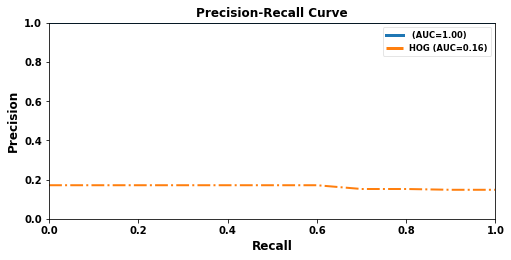

In [21]:
#datapath = 'D:\\workspace\\data\\dataset\\06\\test'
#datapath = 'D:\\workspace\\data\\spring_summer'
datapath = 'D:\workspace\proj7643\CampusLoopDataset'
plot(alexnet,datapath)

# Dataset

# Other model
##### pretrained ones

# Other methods (other than 'projective tranformation + HOG'?)